In [1]:
import torch
from utils.config import create_config
from utils.common_config import get_model

from termcolor import colored


In [2]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = False

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from natsort import natsorted
import scipy.io as sio
import os
import torch
import sys

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [5]:
config_exp = "./configs/nyud/hrnet48/ASN.yml"

In [6]:
p = create_config(config_exp)
print(colored(p, 'red'))

{'setup': 'multi_task', 'train_db_name': 'NYUD_GeoNet', 'val_db_name': 'NYUD_GeoNet', 'trBatch': 8, 'valBatch': 8, 'nworkers': 8, 'gpu0_bsz': 2, 'epochs': 20, 'optimizer': 'adam', 'optimizer_kwargs': {'lr': 5e-05, 'weight_decay': 0.0001}, 'scheduler': 'poly', 'model': 'geodepthnet', 'backbone': 'hrnet_w48', 'backbone_kwargs': {'pretrained': False, 'dilated': False}, 'head': 'hrnet', 'use_guidance': True, 'use_probability': False, 'normal_loss': True, 'guidance_reduce': True, 'use_gt_depth': False, 'task_dictionary': {'include_depth': True}, 'auxilary_task_dictionary': {'include_depth': True}, 'TASKS': {'NAMES': ['depth'], 'NUM_OUTPUT': {'depth': 1}, 'FLAGVALS': {'image': 1, 'depth': 1}, 'INFER_FLAGVALS': {'depth': 1}}, 'depthloss': 'l1', 'ALL_TASKS': {'NAMES': ['depth'], 'NUM_OUTPUT': {'depth': 1}, 'FLAGVALS': {'image': 1, 'depth': 1}, 'INFER_FLAGVALS': {'depth': 1}}, 'AUXILARY_TASKS': {'NAMES': ['depth'], 'NUM_OUTPUT': {'depth': 1}, 'FLAGVALS': {'image': 1, 'depth': 1}, 'INFER_FLAGVAL

In [7]:
# CUDNN
print(colored('Set CuDNN benchmark', 'blue'))
torch.backends.cudnn.benchmark = True

Set CuDNN benchmark


In [8]:
root = "./sample_data"

In [9]:
save_dir = "./results_asn"


In [10]:
# obtain transformations
from torchvision import transforms
from data import custom_transforms as tr
transforms_ts = []
transforms_ts.extend([tr.AddIgnoreRegions(), tr.ToTensor(),
                      tr.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
transforms_ts = transforms.Compose(transforms_ts)


In [11]:
from data.general_dataset import GeneralDataset
from torch.utils.data import DataLoader
val_dataset = GeneralDataset(root=root, transform=transforms_ts)

        
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, drop_last=False,
                            num_workers=1)



./sample_data
Number of dataset images: 3


In [12]:
model = get_model(p)
model = torch.nn.DataParallel(model).cuda()

task_channels:  [48, 96, 192, 384]
************************************
pasn_if_area True
pasn_if_pa True
k_size 5
sample_num 40
************************************
AdaptiveDepth2normal  k_size:  5   sample_num:  40


In [13]:
checkpoint_file = "./checkpoints/checkpoint_hrnet48.pth.tar"
checkpoint = torch.load(checkpoint_file, map_location='cpu')
try:
    model.load_state_dict(checkpoint)
except:
    print("invalid values")
    

In [14]:
#visualization
from utils.depth2img import Depth2Img
from utils.normal2img import Normal2Img

depth2img = Depth2Img()
normal2img = Normal2Img()


In [15]:
model.eval()
for sample in val_dataloader:
    image = sample['image'].cuda()
    raw_image = sample['original_image'].permute(0,2,3,1).squeeze().cpu().numpy()
    intrinsic = sample['intrinsic'].cuda()
    
    with torch.no_grad():
        result = model(image, intrinsic)
    
    pred_depth = result['depth'].squeeze().cpu().numpy()
    pred_normals = result['normals'].permute(0,2,3,1).squeeze().cpu().numpy()
    guidance_feature = result['guidance_feature'].permute(0,2,3,1).squeeze().cpu().numpy()
    
#     break

/userhome/cs/xxlong/anaconda3/envs/MTL/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [16]:
colored_depth = depth2img(pred_depth)
colored_noramls = normal2img(pred_normals)

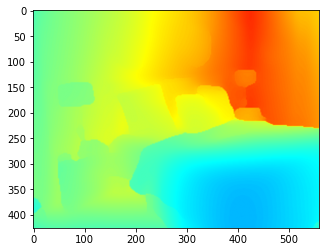

In [17]:
plt.imshow(colored_depth[45:471, 41:601])  # Eigen center crop

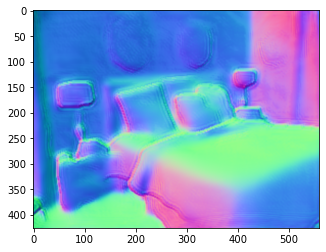

In [18]:
plt.imshow(colored_noramls[45:471, 41:601])  # Eigen center crop

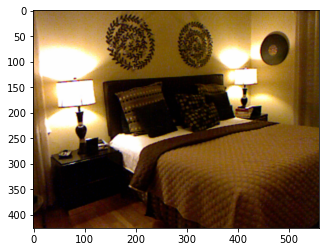

In [19]:
plt.imshow(raw_image[45:471, 41:601])

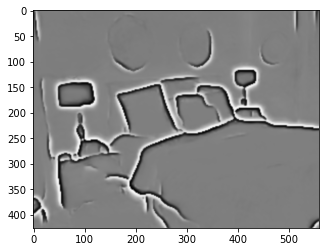

In [20]:
plt.imshow(guidance_feature[45:471, 41:601])